<a href="https://colab.research.google.com/github/Sanket-Kumbhare/Nifty-Prediction/blob/master/models/NiftyPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
ds = pd.read_csv('nifty.csv')
ds

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-07-01,WIPRO,EQ,532.10,534.00,540.00,526.10,535.15,535.75,533.70,939381,5.013447e+13,NaN,114332,0.1217
1,2004-07-02,WIPRO,EQ,535.75,530.50,540.00,501.00,526.90,527.70,531.52,922002,4.900606e+13,NaN,96198,0.1043
2,2004-07-05,WIPRO,EQ,527.70,530.00,534.45,520.10,521.00,523.25,528.32,735599,3.886298e+13,NaN,111809,0.1520
3,2004-07-06,WIPRO,EQ,523.25,522.70,534.70,520.10,533.00,532.15,527.02,730516,3.849963e+13,NaN,99732,0.1365
4,2004-07-07,WIPRO,EQ,532.15,530.00,536.00,513.20,515.50,516.15,522.17,1456674,7.606359e+13,NaN,344091,0.2362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4096,2020-12-24,WIPRO,EQ,385.55,386.45,386.70,378.65,381.80,382.20,382.71,12240172,4.684451e+14,121303.0,2017851,0.1649
4097,2020-12-28,WIPRO,EQ,382.20,383.45,386.40,382.00,383.00,382.90,384.06,4725879,1.815019e+14,52825.0,1133231,0.2398
4098,2020-12-29,WIPRO,EQ,382.90,384.00,390.50,383.10,384.40,385.00,387.04,11459126,4.435100e+14,135489.0,1669549,0.1457
4099,2020-12-30,WIPRO,EQ,385.00,385.00,386.60,382.80,384.60,384.40,384.43,7188435,2.763451e+14,79271.0,1504855,0.2093


In [ ]:
# setting index as date
# ds['Date'] = pd.to_datetime(ds.Date,format='%Y-%m-%d')
# ds.index = ds['Date']

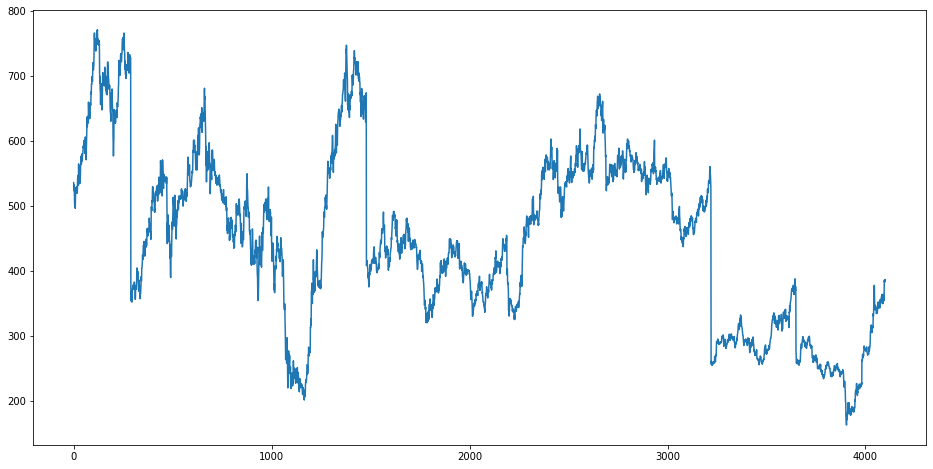

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(ds['Close'], label='Close Price history')

In [ ]:
sc = MinMaxScaler()
train_set=sc.fit_transform(ds['Close'][:2459].values.reshape(-1,1))

### Long short term Memory

In [ ]:
past_days = 30

In [ ]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# define input sequence
timeseries_data = ds['Close'][:6100].tolist()
# choose a number of time steps
n_steps = past_days
# split into samples
X, y = prepare_data(timeseries_data, n_steps)

In [ ]:
X.shape

(4071, 30)

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
callback = [EarlyStopping(monitor='loss', mode='auto',)]
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',)
# fit model
model.fit(X, y, epochs=30, verbose=1)

Epoch 1/30
128/128 [==============================] - 6s 29ms/step - loss: 148810.0910
Epoch 2/30
128/128 [==============================] - 4s 30ms/step - loss: 68718.8877
Epoch 3/30
128/128 [==============================] - 4s 30ms/step - loss: 488996.4624
Epoch 4/30
128/128 [==============================] - 4s 30ms/step - loss: 3994.4114
Epoch 5/30
128/128 [==============================] - 4s 30ms/step - loss: 3342.4917
Epoch 6/30
128/128 [==============================] - 4s 31ms/step - loss: 3564.3908
Epoch 7/30
128/128 [==============================] - 4s 30ms/step - loss: 3139.9456
Epoch 8/30
128/128 [==============================] - 4s 30ms/step - loss: 3563.3895
Epoch 9/30
128/128 [==============================] - 4s 30ms/step - loss: 3222.0757
Epoch 10/30
128/128 [==============================] - 4s 30ms/step - loss: 4200.0448
Epoch 11/30
128/128 [==============================] - 4s 30ms/step - loss: 9153.7774
Epoch 12/30
128/128 [==============================] - 4s 

In [ ]:
model_json = model.to_json()
with open("lstmModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weights.h5")

In [ ]:
dataset = pd.read_csv('wipro.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

[429.6009]
1 day input [396.4        406.3        406.4        406.75       430.2
 446.8        457.7        459.         454.35       438.55
 431.55       430.25       444.95       445.8        444.75
 437.25       446.45       431.9        417.9        421.5
 428.35       433.5        429.9        425.55       435.3
 439.35       439.         437.         442.         429.60089111]
1 day output [[419.35367]]
2 day input [406.3        406.4        406.75       430.2        446.8
 457.7        459.         454.35       438.55       431.55
 430.25       444.95       445.8        444.75       437.25
 446.45       431.9        417.9        421.5        428.35
 433.5        429.9        425.55       435.3        439.35
 439.         437.         442.         429.60089111 419.35366821]
2 day output [[415.63522]]
3 day input [406.4        406.75       430.2        446.8        457.7
 459.         454.35       438.55       431.55       430.25
 444.95       445.8        444.75       437.25    

In [ ]:
len(lst_output)# = sc.inverse_transform(np.array(lst_output).reshape(-1,1))

22

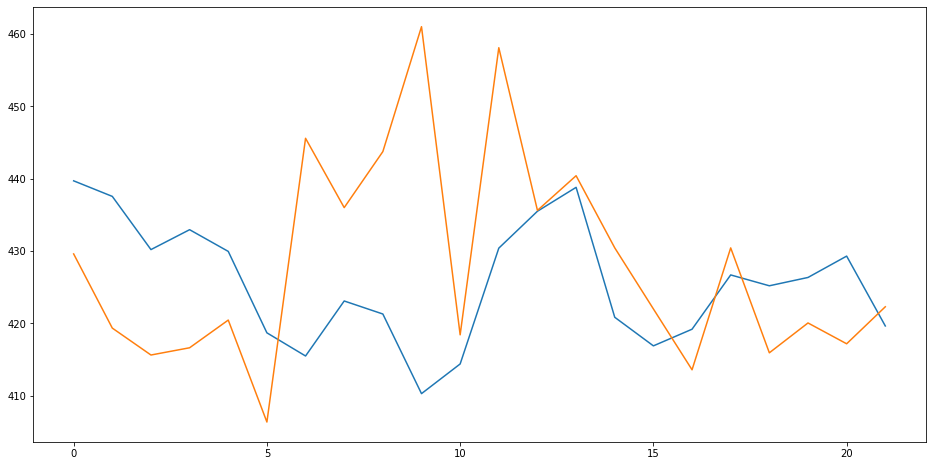

In [ ]:
#original = ds['Close'][2459:].tolist()
plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

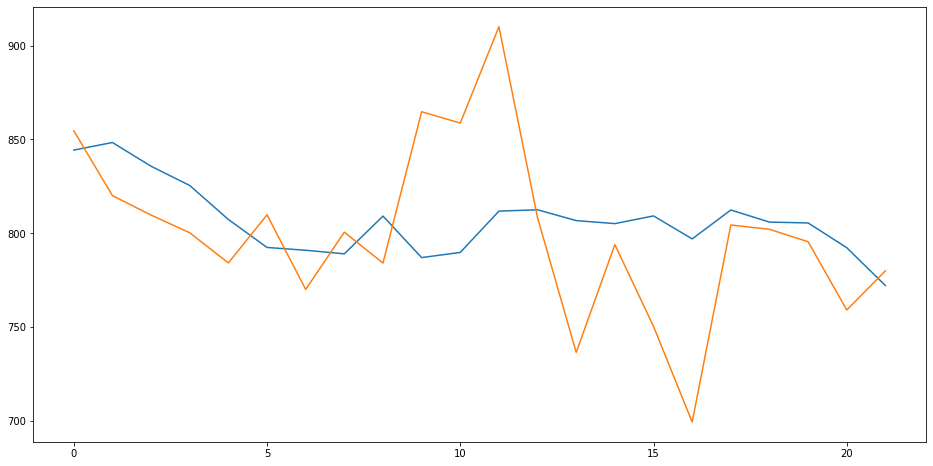

In [ ]:
 dataset = pd.read_csv('cipla.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

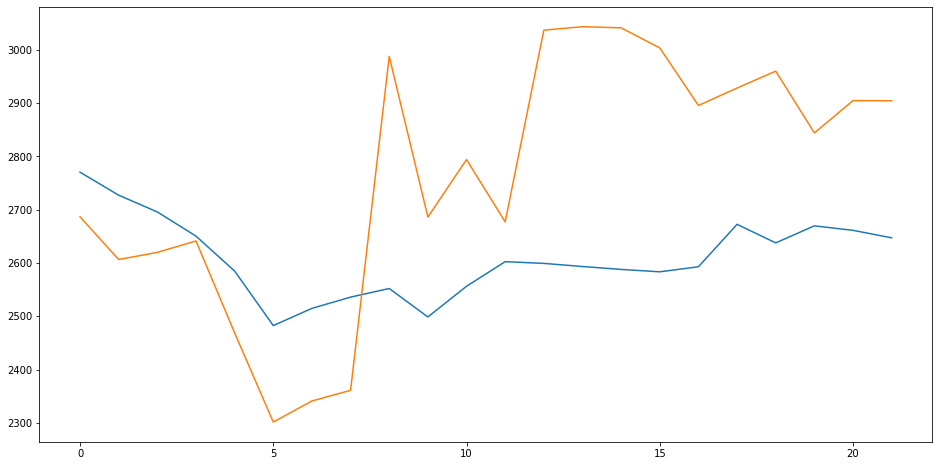

In [ ]:
dataset = pd.read_csv('eichermot.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

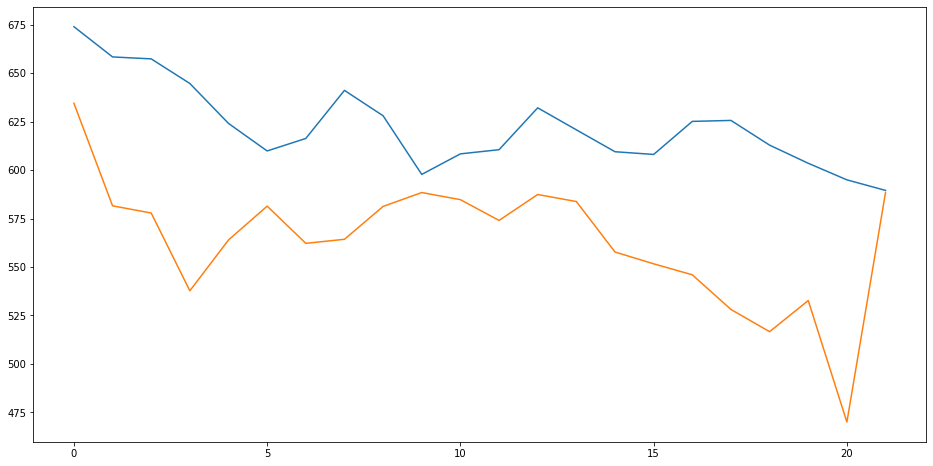

In [ ]:
dataset = pd.read_csv('icicibank.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

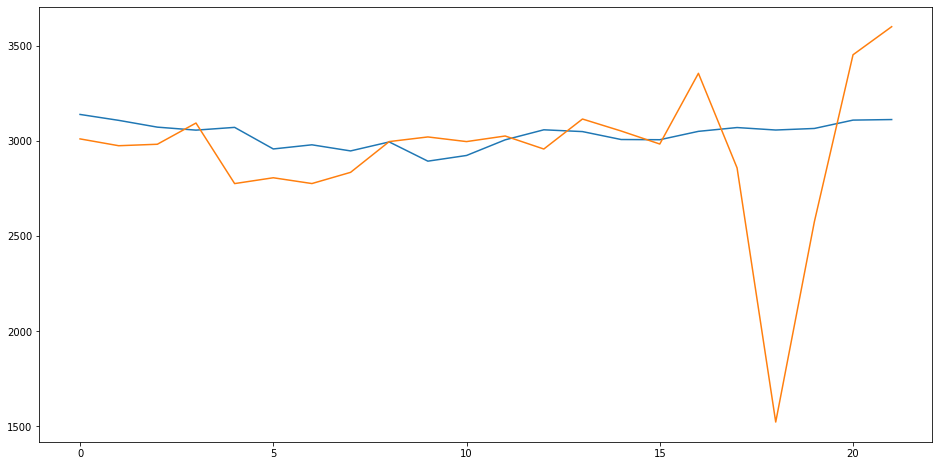

In [ ]:
 dataset = pd.read_csv('tcs.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

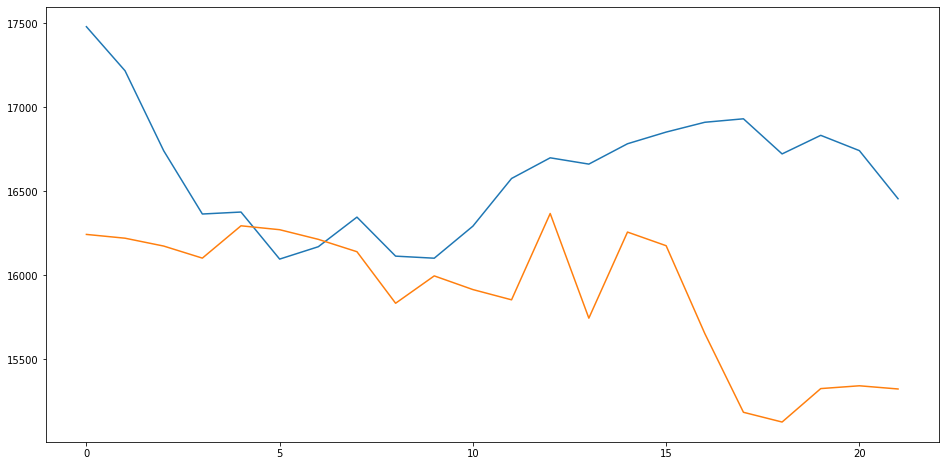

In [ ]:
 dataset = pd.read_csv('nestleind.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

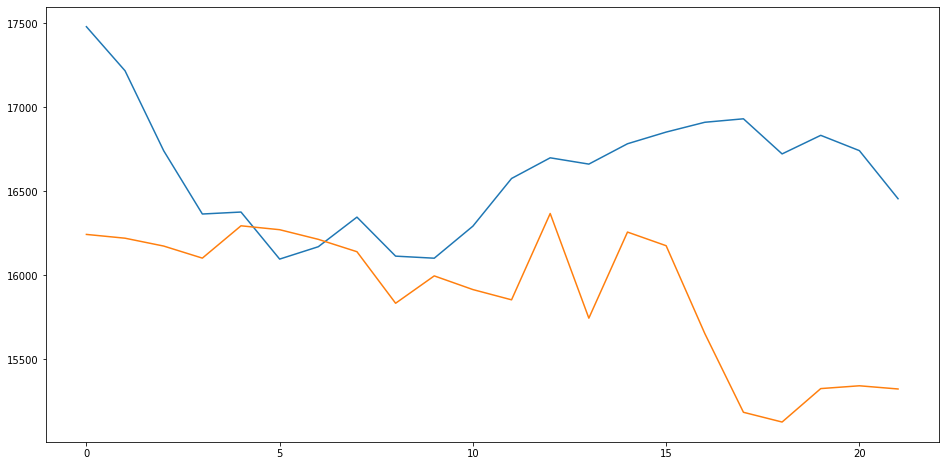

In [ ]:
 dataset = pd.read_csv('nestleind.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)